In [1]:
import tensorflow as tf
import os 
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

In [2]:
class_names = ['Chickenpox', 'Measles', 'Monekypox', 'Normal', 'Others']

In [23]:
input_shape = (224, 224, 3)
num_classes = 4
batch_size = 32
epochs = 20
lr = 0.0003

In [24]:
# Set the paths to the training, test and validation data directories
train_dir = 'data/MSID_US_AUG_SP/train'
val_dir = 'data/MSID_US_AUG_SP/val'

In [25]:
# Create an instance of the ImageDataGenerator class for data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)

# Create an instance of the ImageDataGenerator class for validation data (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

# Create an instance of the ImageDataGenerator class for test data (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
)

# Load the validation data
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
)


Found 3618 images belonging to 4 classes.
Found 1033 images belonging to 4 classes.


In [26]:
# Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# Add a global average pooling layer to reduce the spatial dimensions of the output of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer with the number of units equal to the number of classes for the final prediction
predictions = Dense(num_classes, activation='softmax')(x)

# Create a new model with the input layer of the MobileNetV2 model and the output layer of the fully connected layer
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the MobileNetV2 model to prevent their weights from being updated during training
for layer in base_model.layers:
    layer.trainable = False


optimizier = tf.keras.optimizers.Adam(learning_rate=lr)


# Compile the model
model.compile(optimizer=optimizier,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [29]:
history = model.fit(train_generator, epochs=epochs, batch_size=batch_size, validation_data=val_generator)

Epoch 1/20
 23/114 [=====>........................] - ETA: 26s - loss: 0.1156 - accuracy: 0.9755

KeyboardInterrupt: 

In [19]:
# mobilemiracle = tf.keras.models.load_model('models/mobilenetv2_model.h5')

Found 521 images belonging to 4 classes.
521/521 [==============================] - 7s 13ms/step
Metric              Value               
----------------------------------------
F1 Score            0.9521              
Test Accuracy       0.9520              
Precision           0.9525              
Recall              0.9520              


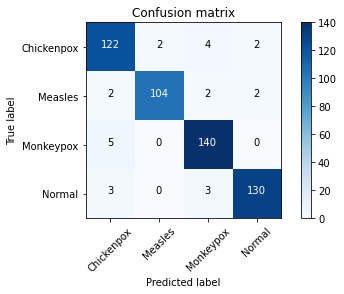

In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

test_dir = 'data/MSID_US_AUG_SP/test'

# Load the test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=1,
    class_mode='categorical',
    shuffle= False
)


# Use the test generator to generate predictions
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get the true labels
y_true = test_generator.classes


# Calculate the evaluation metrics
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)


# Define the evaluation metrics
metrics = ['F1 Score', 'Test Accuracy', 'Precision', 'Recall']
values = [f1,accuracy, precision, recall]

# Print the metrics in a table format
print('{:<20s}{:<20s}'.format('Metric', 'Value'))
print('-' * 40)
for metric, value in zip(metrics, values):
    print('{:<20s}{:<20.4f}'.format(metric, value))

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Define the class names
class_names = list(test_generator.class_indices.keys())

# Define a function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plt.figure()
plot_confusion_matrix(conf_matrix, classes=class_names, normalize=False, title='Confusion matrix')
plt.show()


In [22]:
model.save('models/mobilenetv2_four_classes.h5')

In [17]:
import cv2

# image = cv2.imread('data/MSID/Measles/measles1.png')

image = cv2.imread('test-images/acne-test.jpeg')

# Resize the image to the input size expected by the model
input_size = (224, 224)  # example input size for a model
image = cv2.resize(image, input_size)

# Convert the image to a NumPy array
image = np.array(image)

# Scale the pixel values to be between 0 and 1
image = image / 255.0

# Add an extra dimension to the array to represent the batch size (1 in this case)
image = np.expand_dims(image, axis=0)

# assuming your preprocessed image is stored in a variable named 'preprocessed_image'
prediction = model.predict(image)

predicted_class = np.argmax(prediction)


print(predicted_class)

1/1 [==============================] - 0s 405ms/step
4
